In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st
import statsmodels as sm
import scipy.optimize as opt
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [3]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [4]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [5]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

In [6]:
df = gaz.merge(ropa, on="Data", how="inner").dropna() # zbiorcza tabela połączona po danych - do analizy dwuwymiarowej
df = df.sort_values(['Data'], ascending=[True])

In [7]:
y_gaz = df['Cena gazu [USD/Million Btu]']
y_ropa = df['Cena ropy [USD/Barrel]']

In [8]:
df['przyrosty_log_gaz'] = np.log(y_gaz).diff().dropna()
df['przyrosty_log_ropa'] = np.log(y_ropa).diff().dropna()

In [204]:
class Portfel:
    """Portfel zwrotów logarytmicznych zbudowany na podstawie odsetku ropy w portfelu (reszta to gaz).
    Pozwala łatwo dostać podstawowe metryki.
    """
    def __init__(self,
                 df: pd.DataFrame,
                 odsetek_ropy: float=.5) -> None:
        # assert 0 <= odsetek_ropy <= 1
        self.odsetek_ropy = odsetek_ropy
        self.odsetek_gazu = 1 - odsetek_ropy
        self.usd_na_gaz = np.log(df['Cena gazu [USD/Million Btu]']/6.3).diff().dropna()
        self.usd_na_rope = np.log(df['Cena ropy [USD/Barrel]']).diff().dropna()
    
    @property
    def mean(self):
        return self.odsetek_ropy*self.usd_na_rope.mean() + \
              self.odsetek_gazu*self.usd_na_gaz.mean()
    
    @property
    def var(self):
        return self.odsetek_ropy*self.odsetek_ropy*self.usd_na_rope.var() + \
            self.odsetek_gazu*self.odsetek_gazu*self.usd_na_gaz.var() + \
            2*self.odsetek_gazu*self.odsetek_ropy*self.usd_na_gaz.std()*\
            self.usd_na_rope.std()*np.corrcoef(self.usd_na_gaz[1:],
                                                     self.usd_na_rope[1:])[1,0]
    
    @property
    def risk(self):
        """Just a standard deviation"""
        return np.sqrt(self.var)
    
    @property
    def corr(self):
        return np.corrcoef(self.usd_na_gaz[1:], self.usd_na_rope[1:])[1,0]

    def quantile(self, q):
        return np.quantile(self.usd_na_rope[1:], q)*self.odsetek_ropy + \
            np.quantile(self.usd_na_gaz[1:], q)*self.odsetek_gazu
    
    def __getitem__(self, key):
        return self.usd_na_rope[1:][key]*self.odsetek_ropy + \
            self.usd_na_gaz[1:][key]*self.odsetek_gazu

## Zad 1

In [53]:
print("Średnia gazu: ", df['przyrosty_log_gaz'].mean())
print("Odchylenie standardowe gazu: ", df['przyrosty_log_gaz'].std())
print("Średnia ropy: ",df['przyrosty_log_ropa'].mean())
print("Odchylenie standardowe ropy:", df['przyrosty_log_ropa'].std())

Średnia gazu:  -0.00034018197296326557
Odchylenie standardowe gazu:  0.040322149996107656
Średnia ropy:  0.00026956045325688744
Odchylenie standardowe ropy: 0.0270778848280672


### a)

Zakładam, że rzeczywiste wagi to .8 ropy .2 gazu. Można łatwo zmienić w deklaracji poniżej.

In [54]:
p = Portfel(df, odsetek_ropy=.8)
portfel_values = [p[i] for i in range(len(df['przyrosty_log_ropa'][1:])-1)]

In [55]:
print("Stopa zwrotu portflea: ", p.mean)

Stopa zwrotu portflea:  0.00016815865194466604


std

In [56]:
print("Ryzyko portfela: ", p.risk)

Ryzyko portfela:  0.023795090963527166


corr

In [57]:
p.corr

0.09164168284717195

### b)

In [58]:
space = np.linspace(0, 1, 100)
means = []
risks = []
wallets = [Portfel(df, odsetek_ropy=i) for i in space]
means = [wallet.mean for wallet in wallets]
risks = [wallet.risk for wallet in wallets]

Text(0.5, 0, 'Odsetek ropy w portfelu')

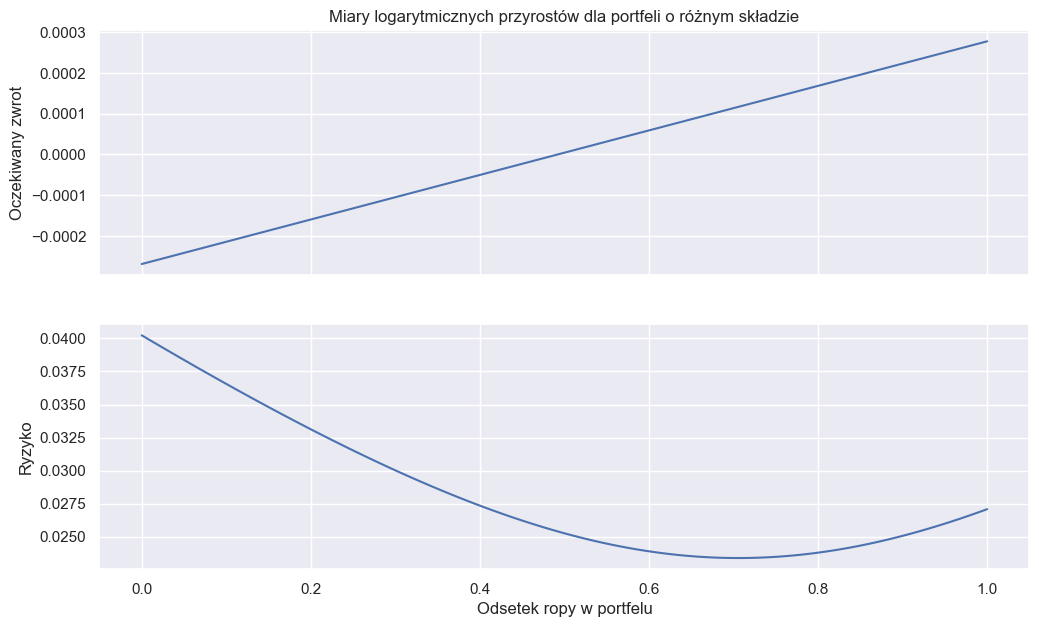

In [59]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(space, means)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli o różnym składzie')
axs[1].plot(space, risks)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')

Text(0.5, 0, 'Ryzyko')

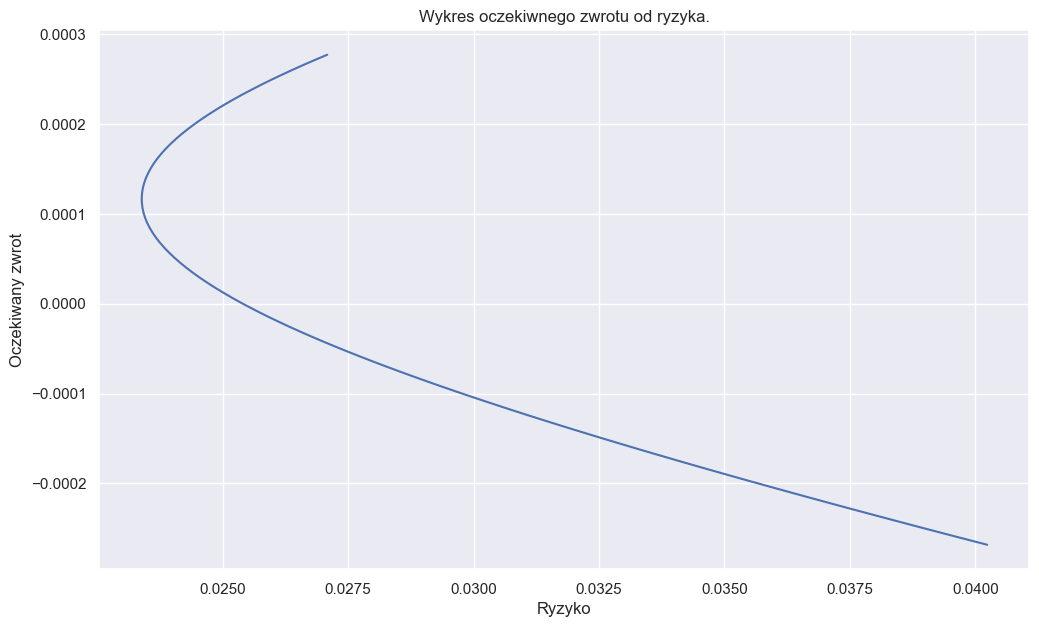

In [61]:
fig, ax = plt.subplots(1,1)
ax.plot(risks, means)
ax.set_title('Wykres oczekiwnego zwrotu od ryzyka.')
ax.set_ylabel('Oczekiwany zwrot')
ax.set_xlabel('Ryzyko')

### c)

In [87]:
def ryzyko(odsetek_ropy):
    """Func to be optimized by opt.minimize"""
    return Portfel(df, odsetek_ropy=odsetek_ropy).risk

In [90]:
opt.minimize(ryzyko, .6978, bounds=[[0,1]], method='Powell', options={'xtol': 1e-14, 'ftol': 1e-14})

   direc: array([[3.27754704e-09]])
     fun: array(0.02338865)
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 2
  status: 0
 success: True
       x: array([0.70561436])

In [91]:
x = 0.69781425

In [92]:
print((1 - x))
print((1 - x)/x)

0.30218575000000003
0.4330461150657213


In [93]:
optimal_wallet = Portfel(df, odsetek_ropy=x)

Stosunek ropy do gazu w protfelu o minimalnym ryzku wynosi 1 : 0.433

LUB

30.218575% gazu i 69.781425% ropy

Ryzyko wynosi 0.02151004

Text(0.5, 0, 'Odsetek ropy w portfelu')

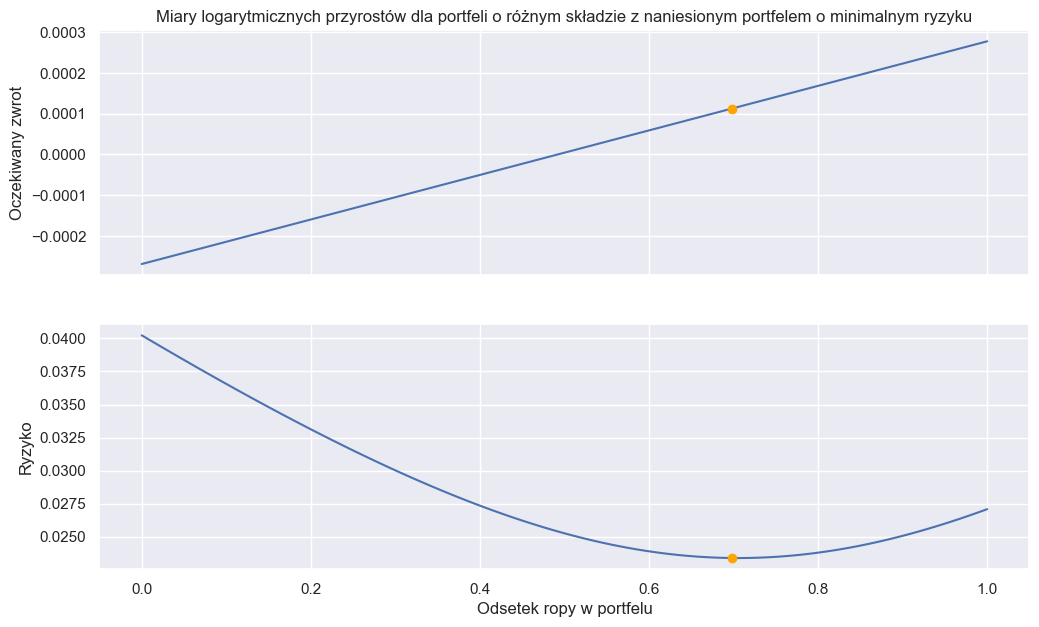

In [94]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(space, means, zorder=1)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli o różnym'
                 ' składzie z naniesionym portfelem o minimalnym ryzyku')
axs[0].scatter(x, optimal_wallet.mean, color="orange", zorder=2)
axs[1].plot(space, risks, zorder=1)
axs[1].scatter(x, optimal_wallet.risk, c="orange", alpha=1, zorder=2)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')

In [95]:
best_wallets = list(filter(lambda x: x.mean > optimal_wallet.mean, wallets))
best_means = [wallet.mean for wallet in best_wallets]
best_risks = [wallet.risk for wallet in best_wallets]

Text(0.5, 0, 'Ryzyko')

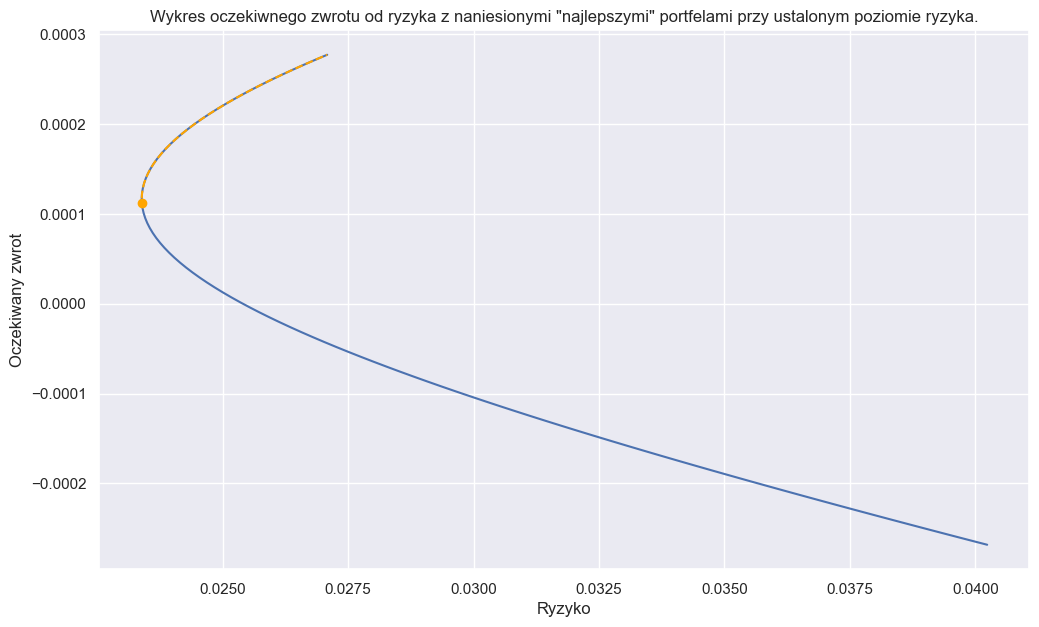

In [96]:
fig, ax = plt.subplots(1,1)
ax.plot(risks, means, zorder=1)
ax.scatter(optimal_wallet.risk, optimal_wallet.mean, c="orange", zorder=2)
ax.plot(best_risks, best_means, linestyle='dashed', c="orange")
ax.set_title('Wykres oczekiwnego zwrotu od ryzyka z naniesionymi "najlepszymi" portfelami przy ustalonym poziomie ryzyka.')
ax.set_ylabel('Oczekiwany zwrot')
ax.set_xlabel('Ryzyko')

### d)

In [71]:
roczna_inflacja = .1620 # na 06.05.2023
EDO0533_w_pierwszym_okresie = .0725

# Stopa na podstawie obligacji dziesięcioletnich EDO0533
# Średnia ważona, zakładam tu że nasza firma co rok kupuje obligacje i ma .1 tych w pierwszym okresie 
# i .9 pozostałych.
# Może da się ją jakoś "poprawniej" wyznaczyć?
stopa_o_minimalnym_ryzyku = .1*EDO0533_w_pierwszym_okresie + .9*(0.0125+roczna_inflacja)
stopa_obligacji = stopa_o_minimalnym_ryzyku

In [38]:
stopa_o_minimalnym_ryzyku

0.16430000000000003

In [39]:
ustalona_stopa_wg_Rafała = stopa_o_minimalnym_ryzyku + 0.01
ustalona_stopa_wg_Rafała

0.17430000000000004

In [73]:
rentownosc_obligacji = .05807
ustalona_plus_punkt_proc = rentownosc_obligacji + .01

Nie wiem czy trzeba to jakoś przeliczyć na logarytmiczną stopę zwrotu? My rozważamy też bardzo krótkie okresy czasu w zwrotach, a tutaj mamy roczny. Stąd pewnie ta różnica w rzędzie wielkości. Pewnie można to przeskalować standardowym wzorkiem z MRFów?

In [74]:
# Przeliczenie stopy obligacji na zwrot dzienny wzorkiem z MRF
k = 365
ustalona_stopa_dzien = (((1+rentownosc_obligacji)**(1/k))-1)

In [75]:
# teraz na stopę logarytmiczną
ustalona_stopa_dzien_log = np.log(1+ustalona_stopa_dzien)

In [81]:
ustalona_stopa_dzien_log

0.00015464792826937562

In [77]:
najmocniejszy_portfel_zwrot = Portfel(df, odsetek_ropy=1).mean
najmocniejszy_portfel_zwrot

0.00027729058446469715

In [127]:
def ryzyko(odsetek_ropy):
    """Func to be optimized by opt.minimize"""
    p = Portfel(df, odsetek_ropy=odsetek_ropy)
    risk = p.risk 
    risk = risk if p.mean >= ustalona_stopa_dzien_log else 1
    return risk

In [198]:
opt.minimize(ryzyko, .8, bounds=[[0,1]], method='Powell', options={'xtol': 1e-14, 'ftol': 1e-14})

   direc: array([[1.]])
     fun: array(0.02361068)
 message: 'Optimization terminated successfully.'
    nfev: 186
     nit: 3
  status: 0
 success: True
       x: array([0.77523965])

In [134]:
optimal_wallet = Portfel(df, odsetek_ropy=0.77523965)

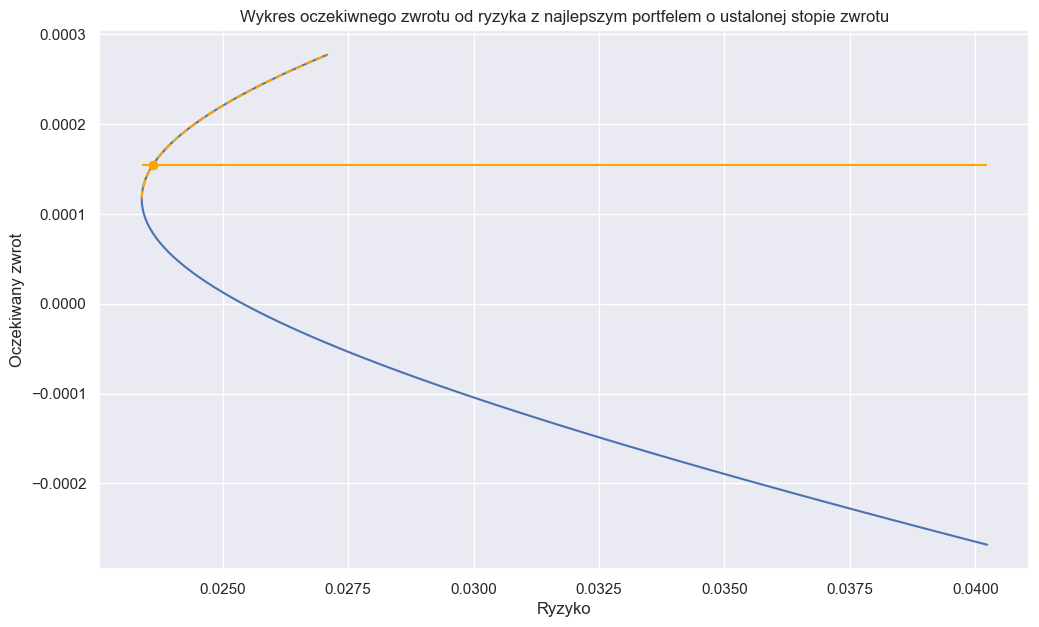

In [224]:
fig, ax = plt.subplots(1,1)
ax.plot(risks, means, zorder=1)
ax.scatter(optimal_wallet.risk, optimal_wallet.mean, c="orange", zorder=2)
ax.plot(best_risks, best_means, linestyle='dashed', c="orange")
ax.set_title('Wykres oczekiwnego zwrotu od ryzyka z najlepszym portfelem o ustalonej stopie zwrotu')
ax.set_ylabel('Oczekiwany zwrot')
ax.set_xlabel('Ryzyko')
ax.hlines(ustalona_stopa_dzien_log, xmin=min(risks), xmax=max(risks), colors="orange")

Trochę cringe, bo obligacje przynoszą ponad dziesięciokrotnie lepszy oczekiwany zysk ze zwrotów logarytmicznych niż najmocniejszy portfel jaki możemy zbudować (z samej ropy).

### Myślę że możemy wziąć dane od 2017 roku (cena ropy była od tego czasu wysoka) i trochę to podreperuje nasz performance

### e)

In [206]:
class PortfelObligacje:
    """Portfel zwrotów logarytmicznych zbudowany na podstawie odsetku ropy w portfelu (reszta to gaz).
    Pozwala łatwo dostać podstawowe metryki.
    """
    stopa_obligacji_log_dzien = np.log(1 + (((1+rentownosc_obligacji)**(1/k))-1))
    
    def __init__(self,
                 df: pd.DataFrame,
                 odsetek_ropy,
                 odsetek_obligacji: float=.5) -> None:
        # assert 0 <= odsetek_ropy <= 1 and 0 <= odsetek_obligacji <= 1
        self._odsetek_ropy = (1 - odsetek_obligacji)*(odsetek_ropy)
        self._odsetek_gazu = (1-odsetek_obligacji)*(1-odsetek_ropy)
        self._odsetek_obligacji = odsetek_obligacji
        self._usd_na_gaz = np.log(df['Cena gazu [USD/Million Btu]']/6.3).diff().dropna()
        self._usd_na_rope = np.log(df['Cena ropy [USD/Barrel]']).diff().dropna()
        print(self._odsetek_ropy, self._odsetek_gazu, self._odsetek_obligacji, (self.mean - self.stopa_obligacji_log_dzien)/self.var)
    
    @property
    def mean(self):
        return self._odsetek_ropy*self._usd_na_rope.mean() + \
              self._odsetek_gazu*self._usd_na_gaz.mean() + \
              self._odsetek_obligacji*self.stopa_obligacji_log_dzien
    
    @property
    def _var_bez_obligacji(self):
        """Taki workaround bo śmieszny wzorek a nie chciało mi się pisać od nowa, niżej już dobry var"""
        return (self._odsetek_ropy*self._odsetek_ropy*self._usd_na_rope.var() + \
            self._odsetek_gazu*self._odsetek_gazu*self._usd_na_gaz.var() + \
            2*self._odsetek_gazu*self._odsetek_ropy*self._usd_na_gaz.std()*\
            self._usd_na_rope.std()*np.corrcoef(self._usd_na_gaz[1:],
                                                     self._usd_na_rope[1:])[1,0])
    
    @property
    def risk(self):
        """Just a standard deviation"""
        return np.sqrt(self._var_bez_obligacji)*(1-self._odsetek_obligacji)

    @property
    def var(self):
        return self.risk*self.risk
    
    # @property
    # def corr(self):
    #     return np.corrcoef(self._usd_na_gaz[1:], self._usd_na_rope[1:])[1,0]

    # def quantile(self, q):
    #     return np.quantile(self._usd_na_rope[1:], q)*self._odsetek_ropy + \
    #         np.quantile(self._usd_na_gaz[1:], q)*self._odsetek_gazu
    
    def __getitem__(self, key):
        return self._usd_na_rope[1:][key]*self._odsetek_ropy + \
            self._usd_na_gaz[1:][key]*self._odsetek_gazu + \
            self._odsetek_obligacji*self.stopa_obligacji_log_dzien

### Portfel z obligacjami nie jest nigdzie użyty. Nie uwzględniam obligacji jako składnika portfela. Jedynia jako odnośnik do oczekiwanej stopy zwrotu wyżej.

In [217]:
def wskaznik_Sharpa(odsetek_ropy):
    p = Portfel(df, odsetek_ropy)
    sharp = -(p.mean - PortfelObligacje.stopa_obligacji_log_dzien)/p.var
    print(-sharp, odsetek_ropy)
    return sharp

In [219]:
opt.minimize(wskaznik_Sharpa, .1, bounds=[[0,1]], method='Powell', options={'xtol': 1e-5, 'ftol': 1e-5})

[-0.2756696] [0.1]
[-0.27778414] [0.38196601]
[-0.15221758] [0.61803399]
[-0.01113036] [0.76393202]
[0.0723844] [0.85410197]
[0.11532667] [0.90983006]
[0.13773674] [0.94427191]
[0.14996532] [0.96555815]
[0.156911] [0.97871376]
[0.16097377] [0.98684438]
[0.16339804] [0.99186938]
[0.16486354] [0.994975]
[0.16575682] [0.99689438]
[0.16630417] [0.99808062]
[0.16664064] [0.99881376]
[0.1668479] [0.99926686]
[0.16697574] [0.9995469]
[0.16705464] [0.99971997]
[0.16710337] [0.99982693]
[0.16713347] [0.99989304]
[0.16715207] [0.99993389]
[0.16716356] [0.99995914]
[0.16717066] [0.99997475]
[0.16717505] [0.99998439]
[0.16717776] [0.99999036]
[0.16717944] [0.99999404]
[0.16963704] [1.89998808]
[-0.27778414] [0.38196601]
[-0.15221758] [0.61803399]
[-0.01113036] [0.76393202]
[0.0723844] [0.85410197]
[0.11532667] [0.90983006]
[0.13773674] [0.94427191]
[0.14996532] [0.96555815]
[0.156911] [0.97871376]
[0.16097377] [0.98684438]
[0.16339804] [0.99186938]
[0.16486354] [0.994975]
[0.16575682] [0.99689438]

   direc: array([[-3.54417136e-11]])
     fun: array(-0.16718215)
 message: 'Optimization terminated successfully.'
    nfev: 240
     nit: 3
  status: 0
 success: True
       x: array([1.])

In [220]:
rynkowy_wallet = Portfel(df, 1)

### Optymalny indeks Sharpe'a jest równy 0.16718215

Text(0.5, 0, 'Ryzyko')

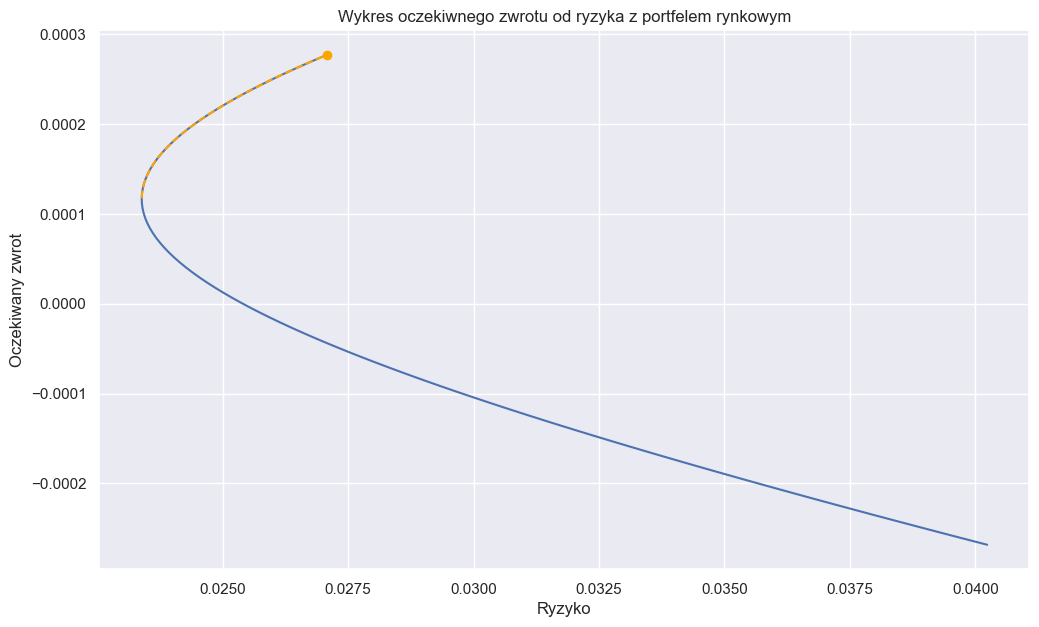

In [223]:
fig, ax = plt.subplots(1,1)
ax.plot(risks, means, zorder=1)
ax.scatter(rynkowy_wallet.risk,rynkowy_wallet.mean, c="orange", zorder=2)
ax.plot(best_risks, best_means, linestyle='dashed', c="orange")
ax.set_title('Wykres oczekiwnego zwrotu od ryzyka z portfelem rynkowym')
ax.set_ylabel('Oczekiwany zwrot')
ax.set_xlabel('Ryzyko')